In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from back_tester import * 
from deep_q_learning_improved import *
from collections import Counter


# Fix seed for reproducibility
---

In [2]:
# ─── FIX RANDOM SEEDS ───────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED) #Sets the seed for Python’s built-in random module.
np.random.seed(SEED) #Sets the seed for NumPy’s random number generator.
torch.manual_seed(SEED) #Sets the seed for PyTorch CPU operations.
# if you’re using CUDA:
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    # make CuDNN deterministic (may slow you down a bit)
    torch.backends.cudnn.deterministic   = True
    torch.backends.cudnn.benchmark       = False
# ────────────────────────────────────────────────────────────────────────────────



# Load data
---

In [3]:
#Data
prices = pd.read_csv('tardis_data/final_in_sample_dataset/final_in_sample_dataset_5min_2024.csv', index_col=0, parse_dates=True)
prices = prices[['MANAUSDT_2024_5m', 'SANDUSDT_2024_5m']]

# EDD
---

In [4]:
# # Load your precomputed z-score spreads and raw prices as NumPy arrays

# window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!


# sym1, sym2 = prices.columns
# S1 = prices[sym1]
# S2 = prices[sym2]

# print("Computing spread series and beta series...")
# # Compute the spread series and beta_series 
# spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
# #print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# # Compute rolling z-score using the provided helper function.
# zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)

# #Drop NaN values from zscore_series
# zscore_series = zscore_series.dropna()

# #Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
# prices = prices.loc[zscore_series.index]
# beta_series = beta_series.loc[zscore_series.index]


In [5]:
# # 1) Prepare a DataFrame to collect per‐cycle features

# spreads = zscore_series


# records = []
# for period, month_df in spreads.groupby(spreads.index.to_period("M")):
#     # slice out that month’s data
#     z = spreads[spreads.index.to_period("M") == period]
#     p = prices.loc[z.index]
#     b = beta_series.loc[z.index]

#     # build a mini‐env just to extract cycles
#     env = PairsTradingEnv(z, p, b, initial_capital=1.0, tx_cost=0.0, entry_stop_pairs=[(1, 2), (2, 3), (3, 4)], eval_mode=True) #Make eval mode false for now
#     env.create_cycles(min_threshold=1.0, tol=0.10)

#     # for each cycle, grab summary stats
#     for cycle in env.spread_cycles:
#         records.append({
#             "month": str(period),
#             "entry_z": cycle.iloc[0],
#             "cycle_mean": cycle.mean(),
#             "cycle_std": cycle.std(),
#             "cycle_length": len(cycle),
#             "cycle_min": cycle.min(),
#             "cycle_max": cycle.max(),
#             "Absolute max": max(cycle.max(), abs(cycle.min())),
#         })

# df_cycles = pd.DataFrame(records)

In [6]:
# df_cycles

In [7]:

# # 2) Look at how entry_z distributions shift month→month
# plt.figure(figsize=(10,6))
# df_cycles.boxplot(column="entry_z", by="month", rot=45)
# plt.title("Distribution of Cycle Entry Z‐Scores by Month")
# plt.suptitle(""); plt.ylabel("Entry Z-Score")
# plt.tight_layout()
# plt.show()

# # 3) Similarly you can do cycle_length, cycle_std, etc.
# for feat in ["cycle_length","cycle_std","cycle_min","cycle_max"]:
#     plt.figure(figsize=(10,4))
#     df_cycles.boxplot(column=feat, by="month", rot=45)
#     plt.title(f"{feat} by Month")
#     plt.suptitle(""); plt.ylabel(feat)
#     plt.tight_layout()
#     plt.show()

# # 4) Or even a heatmap of mean/std per month
# summary = df_cycles.groupby("month")[["entry_z","cycle_length","cycle_std"]].agg(["mean","std"])
# print(summary)


* ## Training set

---

In [8]:

#prices_train = prices.loc['2024-01-01 00:00:00':'2024-04-30 23:55:00'] #January training data

prices_train = prices.loc['2024-01-01 00:00:00':'2024-04-30 23:55:00'] #January training data

#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_train, sym2_train = prices_train.columns
S1_train = prices_train[sym1_train]
S2_train = prices_train[sym2_train]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_train, beta_series_train, alpha_series_train = compute_spread_series(S1_train, S2_train, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_train, rolling_mean_train, rolling_std_train = compute_rolling_zscore(spread_series_train, window_size)

#Drop NaN values from zscore_series
zscore_series_train = zscore_series_train.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_train = prices_train.loc[zscore_series_train.index]
beta_series_train = beta_series_train.loc[zscore_series_train.index]


Computing spread series and beta series...


---

* ## Validation set

---

In [9]:

#prices_val = prices.loc['2024-05-01 00:00:00':'2024-05-31 23:55:00'] #May val data
prices_val = prices.loc['2024-05-01 00:00:00':'2024-05-30 23:55:00'] #May val data


#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_val, sym2_val = prices_val.columns
S1_val = prices_val[sym1_val]
S2_val = prices_val[sym2_val]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_val, beta_series_val, alpha_series_val = compute_spread_series(S1_val, S2_val, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_val, rolling_mean_val, rolling_std_val = compute_rolling_zscore(spread_series_val, window_size)

#Drop NaN values from zscore_series
zscore_series_val = zscore_series_val.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_val = prices_val.loc[zscore_series_val.index]
beta_series_val = beta_series_val.loc[zscore_series_val.index]


Computing spread series and beta series...


In [10]:
prices_val

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2024-05-03 00:00:00,0.4315,0.4341
2024-05-03 00:05:00,0.4323,0.4352
2024-05-03 00:10:00,0.4324,0.4348
2024-05-03 00:15:00,0.4316,0.4339
2024-05-03 00:20:00,0.4315,0.4335
...,...,...
2024-05-30 23:35:00,0.4454,0.4386
2024-05-30 23:40:00,0.4452,0.4386
2024-05-30 23:45:00,0.4457,0.4389


---

* ## Test set

---

In [11]:

#prices_test = prices.loc['2024-06-01 00:00:00':'2024-06-29 23:55:00']
prices_test = prices.loc['2024-06-01 00:00:00':'2024-06-30 23:55:00']


#Only use the first month of prices for now
# start_date = pd.to_datetime('2024-01-01 00:00:00')
# end_date = pd.to_datetime('2024-01-31 23:55:00') 

#prices = prices.loc[start_date:end_date] # 2880 rows = 1 month of 5-minute data

#Params for spread calculation
window_size = 288 # It seems like as this increases, the percent absolute delta beta error decreases!

# Load your precomputed z-score spreads and raw prices as NumPy arrays
sym1_test, sym2_test = prices_test.columns
S1_test = prices_test[sym1_test]
S2_test = prices_test[sym2_test]

print("Computing spread series and beta series...")
# Compute the spread series and beta_series 
spread_series_test, beta_series_test, alpha_series_test = compute_spread_series(S1_test, S2_test, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series_test, rolling_mean_test, rolling_std_test = compute_rolling_zscore(spread_series_test, window_size)

#Drop NaN values from zscore_series
zscore_series_test = zscore_series_test.dropna()

#Esnure prices and beta_series are aligned with zscore_series after dropping NaN values in the zscore_series
prices_test = prices_test.loc[zscore_series_test.index]
beta_series_test = beta_series_test.loc[zscore_series_test.index]


Computing spread series and beta series...


In [12]:
prices_test

,MANAUSDT_2024_5m,SANDUSDT_2024_5m
timestamp,,
2024-06-03 01:15:00,0.4433,0.4378
2024-06-03 01:20:00,0.4458,0.4400
2024-06-03 01:25:00,0.4464,0.4407
2024-06-03 01:30:00,0.4474,0.4424
2024-06-03 01:35:00,0.4468,0.4416
...,...,...
2024-06-29 23:20:00,0.3312,0.3263
2024-06-29 23:35:00,0.3311,0.3261
2024-06-29 23:40:00,0.3307,0.3259


---

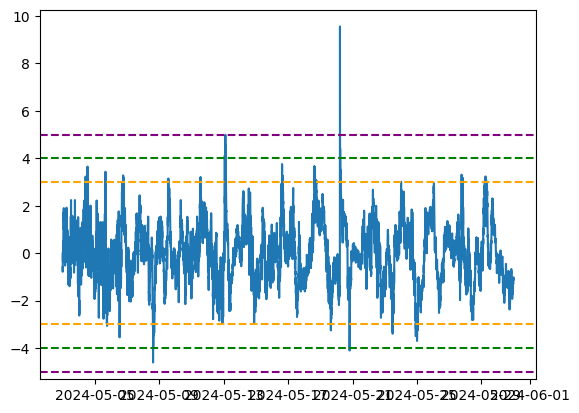

In [13]:
plt.plot(zscore_series_val, label='Train Z-Score')
plt.axhline(3, color='orange', linestyle='--', label='Upper Threshold')
plt.axhline(-3, color='orange', linestyle='--', label='Lower Threshold')
plt.axhline(4, color='g', linestyle='--', label='Upper Threshold')
plt.axhline(-4, color='g', linestyle='--', label='Lower Threshold')
plt.axhline(5, color='purple', linestyle='--', label='Upper Threshold')
plt.axhline(-5, color='purple', linestyle='--', label='Lower Threshold')

# Train agent
---

In [14]:

print("Training DQN agent...")
# Define your discrete threshold pairs: [(entry1, stop1), (entry2, stop2), ...]
entry_stop_pairs = [(1, 2), (2, 3),(3, 4),(4,5)]
# Training parameters
initial_capital = 10_000
tx_cost = 0

online_net, replay_buffer,epoch_loss_history, reward_history,validation_reward_history,training_metrics = train_dqn(
                                                                                        zscore_series_train, 
                                                                                        prices_train, 
                                                                                        beta_series_train,
                                                                                        zscore_series_val,
                                                                                        prices_val,
                                                                                        beta_series_val,
                                                                                        initial_capital,
                                                                                        tx_cost,
                                                                                        entry_stop_pairs, 
                                                                                        num_epochs=500,
                                                                                        batch_size=32,
                                                                                        gamma = 0.99,
                                                                                        lr = 0.001,
                                                                                        epsilon_start = 1,
                                                                                        epsilon_end = 0.01,
                                                                                        epsilon_decay = 0.995,
                                                                                        replay_capacity = 1000,
                                                                                        target_update_freq = 10,
                                                                                        hidden_dim = 64,                                           
                                                                                        )

# Save the trained model
torch.save(online_net.state_dict(), 'dqn_model.pth')


Training DQN agent...
Epoch 01 | AvgReward: -0.55 | Epsilon: 0.995
Epoch 02 | AvgReward: -0.49 | Epsilon: 0.990
Epoch 03 | AvgReward: -0.43 | Epsilon: 0.985
Epoch 04 | AvgReward: -0.47 | Epsilon: 0.980
Epoch 05 | AvgReward: -0.51 | Epsilon: 0.975
Epoch 06 | AvgReward: -0.44 | Epsilon: 0.970
Epoch 07 | AvgReward: -0.46 | Epsilon: 0.966
Epoch 08 | AvgReward: -0.45 | Epsilon: 0.961
Epoch 09 | AvgReward: -0.52 | Epsilon: 0.956
Epoch 10 | AvgReward: -0.52 | Epsilon: 0.951
Epoch 11 | AvgReward: -0.52 | Epsilon: 0.946
Epoch 12 | AvgReward: -0.48 | Epsilon: 0.942
Epoch 13 | AvgReward: -0.41 | Epsilon: 0.937
Epoch 14 | AvgReward: -0.45 | Epsilon: 0.932
Epoch 15 | AvgReward: -0.40 | Epsilon: 0.928
Epoch 16 | AvgReward: -0.41 | Epsilon: 0.923
Epoch 17 | AvgReward: -0.39 | Epsilon: 0.918
Epoch 18 | AvgReward: -0.47 | Epsilon: 0.914
Epoch 19 | AvgReward: -0.49 | Epsilon: 0.909
Epoch 20 | AvgReward: -0.41 | Epsilon: 0.905
Epoch 21 | AvgReward: -0.48 | Epsilon: 0.900
Epoch 22 | AvgReward: -0.52 | Eps

# Best thresholds
---

Counter({(1, 2): 301, (2, 3): 127, (3, 4): 60, (4, 5): 12, None: 3})


Text(0.5, 1.0, 'Oracle‐best Entry–Stop Pair Coverage (Training set)')

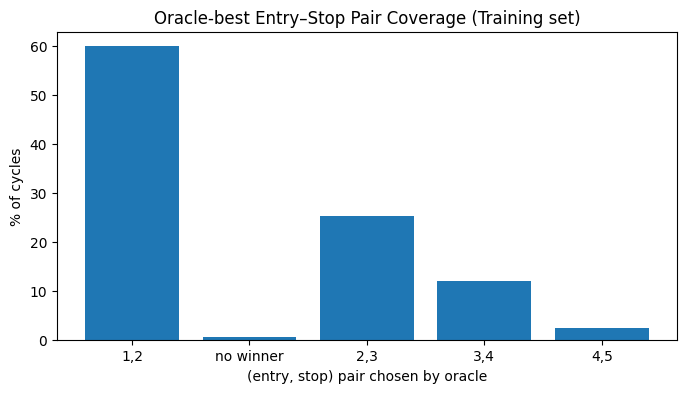

In [15]:
env = PairsTradingEnv(zscore_series_train, prices_train, beta_series_train, initial_capital, tx_cost, entry_stop_pairs, eval_mode=True)
best_pairs_train = env.find_best_thresholds()
spread_cycles_train = env.spread_cycles

#best_pairs_train = find_best_thresholds(entry_stop_pairs,zscore_series_train,prices_train,beta_series_train)

# Suppose best_pairs is your list of length N containing either (e,s) or None
counts = Counter(best_pairs_train)   # Now counts[None] is how many cycles had no winning pair
total  = len(best_pairs_train)

# Convert raw counts to percentages
pairs    = list(counts.keys())
percent_train  = [counts[p] / total * 100 for p in pairs]

# Turn None → a string label
labels = [
    "no winner" if p is None else f"{p[0]},{p[1]}"
    for p in pairs
]

print(counts)

# Plot
plt.figure(figsize=(8,4))
bars = plt.bar(range(len(labels)), percent_train, tick_label=labels)
plt.ylabel("% of cycles")
plt.xlabel("(entry, stop) pair chosen by oracle")
plt.title("Oracle‐best Entry–Stop Pair Coverage (Training set)")




Text(0.5, 1.0, 'Z-Score Series with Cycles illustration (for training set)')

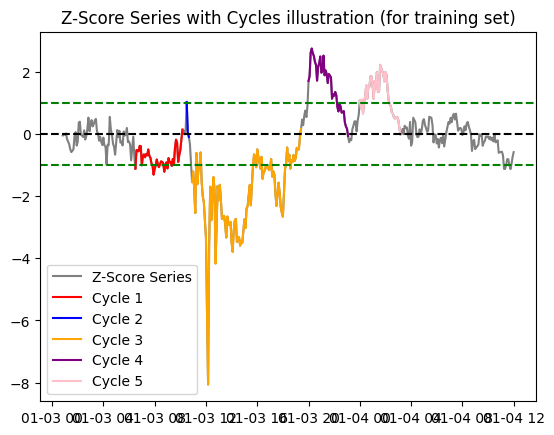

In [16]:
plt.plot(zscore_series_train.iloc[0:420], color = 'grey', label='Z-Score Series')
plt.plot(spread_cycles_train[0], color = 'r', label='Cycle 1')
plt.plot(spread_cycles_train[1], color = 'b' , label='Cycle 2')
plt.plot(spread_cycles_train[2], color = 'orange' , label='Cycle 3')
plt.plot(spread_cycles_train[3], color = 'purple' , label='Cycle 4')
plt.plot(spread_cycles_train[4], color = 'pink' , label='Cycle 5')
plt.axhline(0, color = 'black', linestyle='--')
plt.axhline(1, color = 'green', linestyle='--')
plt.axhline(-1, color = 'green', linestyle='--')
plt.legend(loc='lower left')
plt.title('Z-Score Series with Cycles illustration (for training set)')

# Training performance
---

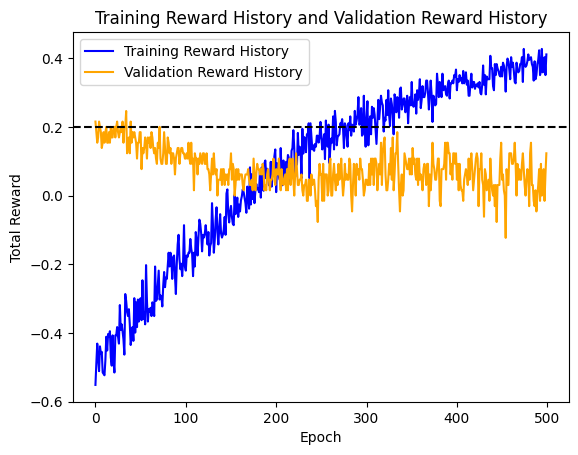

In [17]:
plt.plot(reward_history, color = 'blue', label = 'Training Reward History')
plt.plot(validation_reward_history, color = 'orange', label = 'Validation Reward History')
plt.title('Training Reward History and Validation Reward History')
plt.axhline(0.2, color = 'black', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

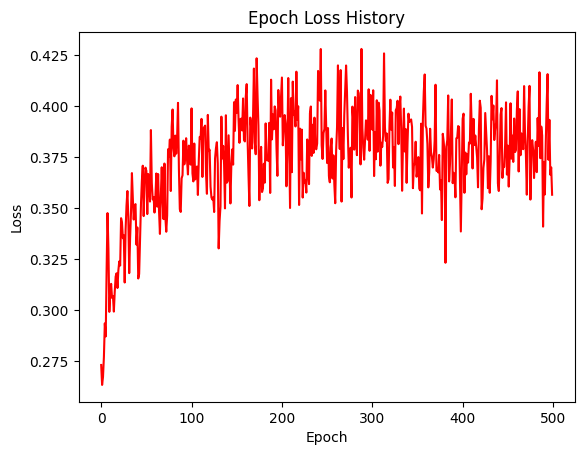

In [18]:
plt.plot(epoch_loss_history, color = 'red')
plt.title('Epoch Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Final win rates:  0.7054108216432866
Final loss rates:  0.17835671342685372
Final forced rates:  0.0
Final none rates:  0.11623246492985972


Text(0.5, 0, 'Epoch')

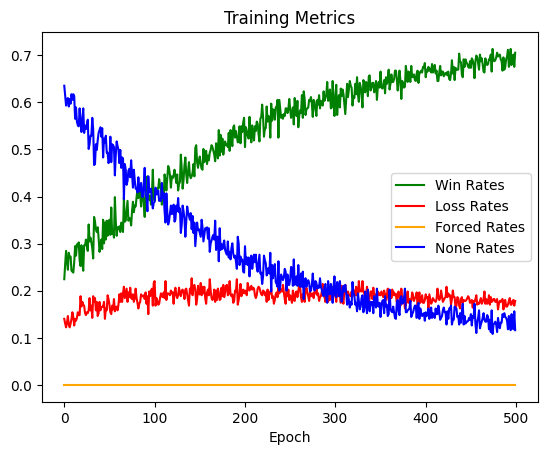

In [19]:
win_rates = training_metrics['win_rates']
loss_rates = training_metrics['loss_rates']
forced_rates = training_metrics['forced_rates']
none_rates = training_metrics['no_trade_rates']

print("Final win rates: ", win_rates[-1])
print("Final loss rates: ", loss_rates[-1])
print("Final forced rates: ", forced_rates[-1])
print("Final none rates: ", none_rates[-1])


plt.plot(win_rates, color = 'green',label = 'Win Rates')
plt.plot(loss_rates, color = 'red', label = 'Loss Rates')
plt.plot(forced_rates, color = 'orange', label = 'Forced Rates')
plt.plot(none_rates, color = 'blue', label = 'None Rates')

plt.legend()
plt.title('Training Metrics')
plt.xlabel('Epoch') 

# Evaluate
---

In [20]:
#Recreate the model and load the saved state_dict
online_net_trained = DQN(input_dim=6, output_dim=len(entry_stop_pairs), hidden_dim=64)# Load the saved state_dict into the model
online_net_trained.load_state_dict(torch.load('dqn_model.pth'))



<All keys matched successfully>

In [21]:
tx_cost = 0.000

#define test environment
env_test = PairsTradingEnv(zscore_series_test, prices_test, beta_series_test, initial_capital, tx_cost, entry_stop_pairs, eval_mode=True)

#TEST SET
test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
    env_test,
    online_net_trained,
    entry_stop_pairs,
)
print(test_metrics)

#TRAINING SET

# test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
#     online_net_trained,
#     zscore_series_train,
#     prices_train,
#     beta_series_train,
#     initial_capital,
#     tx_cost,
#     entry_stop_pairs,
# )
# print(test_metrics)

#VALIDATION SET

# test_rewards,trade_profits,actions,episodes,test_metrics = evaluate_dqn(
#     online_net_trained,
#     zscore_series_val,
#     prices_val,
#     beta_series_val,
#     initial_capital,
#     tx_cost,
#     entry_stop_pairs,
# )
# print(test_metrics)



{'avg_reward': np.float64(0.05660377358490566), 'win_rate': 0.5283018867924528, 'loss_rate': 0.3113207547169811, 'forced_rate': 0.0, 'no_trade_rate': 0.16037735849056603}


In [22]:
len(trade_profits)  

106

In [23]:
actions_profits_list = zip(actions,trade_profits)
actions_profits_df = pd.DataFrame(actions_profits_list, columns=['Actions', 'Trade Profits'])

#Show all rows
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

# actions_profits_df_zeros = actions_profits_df[actions_profits_df['Trade Profits'] > 0]
#actions_profits_df_zeros

actions_profits_df.head(50)

,Actions,Trade Profits
0,"(1, 2)",15.544209
1,"(2, 3)",-4.397513
2,"(1, 2)",0.000000
3,"(3, 4)",0.000000
4,"(1, 2)",-21.575084
5,"(1, 2)",32.399202
6,"(2, 3)",0.000000
7,"(1, 2)",14.467981
8,"(1, 2)",-23.698293
9,"(1, 2)",-20.948541


percentages:  [80.18867924528303, 15.09433962264151, 4.716981132075472]


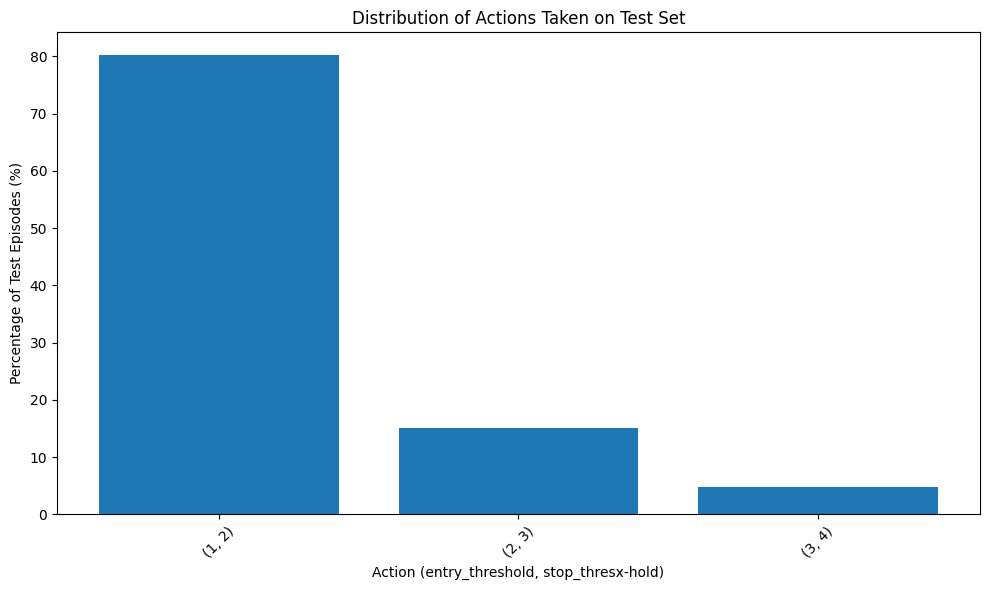

In [24]:
#Count number of each action in the actions list
from collections import Counter

# 1. Count how many times each action appears
counts = Counter(actions)
total = len(actions)

# 2. Compute percentages
actions_sorted = sorted(counts.keys())
percentages = [counts[a] / total * 100 for a in actions_sorted]

print("percentages: ", percentages)


# 4. Plot the distribution
plt.figure(figsize=(10, 6))
plt.bar(range(len(actions_sorted)), percentages)
plt.xticks(range(len(actions_sorted)), [f"{a}" for a in actions_sorted], rotation=45)
plt.ylabel("Percentage of Test Episodes (%)")
plt.xlabel("Action (entry_threshold, stop_thresx-hold)")
plt.title("Distribution of Actions Taken on Test Set")
plt.tight_layout()
plt.show()

(array([ 5.,  0.,  2.,  0.,  2.,  3.,  1.,  5.,  2.,  3.,  4.,  1.,  1.,
         2.,  1.,  0.,  2.,  1.,  1., 17.,  0.,  0.,  0.,  0.,  1.,  0.,
         2.,  4.,  5.,  7.,  6.,  5.,  3.,  2.,  3.,  1.,  2.,  1.,  0.,
         3.,  4.,  0.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-27.42803007, -26.04656554, -24.66510101, -23.28363647,
        -21.90217194, -20.52070741, -19.13924288, -17.75777835,
        -16.37631381, -14.99484928, -13.61338475, -12.23192022,
        -10.85045569,  -9.46899115,  -8.08752662,  -6.70606209,
         -5.32459756,  -3.94313303,  -2.5616685 ,  -1.18020396,
          0.20126057,   1.5827251 ,   2.96418963,   4.34565416,
          5.7271187 ,   7.10858323,   8.49004776,   9.87151229,
         11.25297682,  12.63444136,  14.01590589,  15.39737042,
         16.77883495,  18.16029948,  19.54176402,  20.92322855,
         22.30469308,  23.68615761,  25.06762214,  26.44908668,
         27.83055121,  29.21201574,  30.59348027,  31.9749448 ,
         33.

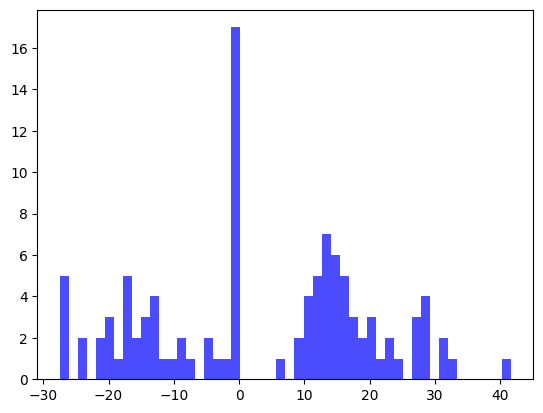

In [25]:
plt.hist(trade_profits, bins=50, color='blue', alpha=0.7)

Final returns:  3.896401908526284 %


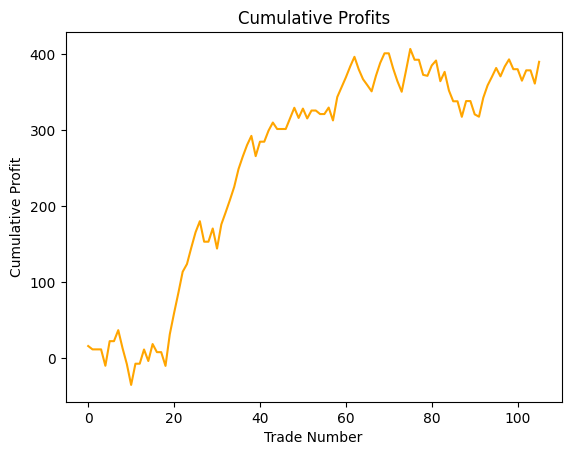

In [26]:
cumulative_profits = np.cumsum(trade_profits)
print("Final returns: ", cumulative_profits[-1]/initial_capital * 100, "%")
plt.plot(cumulative_profits, color='orange')
plt.title('Cumulative Profits')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Profit')
plt.show()

[np.float64(20.628936285104466), np.float64(15.544209333949906), np.float64(-21.63286766272007), np.float64(-9.469379059075372), np.float64(-21.575084089831314), np.float64(32.39920204867961), np.float64(17.469277251128823), np.float64(14.467981153004807), np.float64(-23.69829275425726), np.float64(-20.9485413275421), np.float64(-27.428030070205683), np.float64(27.923680540597303), np.float64(22.539354555411695), np.float64(18.706183839512168), np.float64(-15.152291456564676), np.float64(22.329943273108444), np.float64(-5.926726886188451), np.float64(11.38118456445202), np.float64(-18.099172492465414), np.float64(59.20752799723482), np.float64(41.645196527206075), np.float64(27.931260791166537), np.float64(26.544534633363522), np.float64(27.78510348064149), np.float64(10.18081864285761), np.float64(21.43854902413759), np.float64(20.36417629996457), np.float64(14.573430944151362), np.float64(-26.98727626241942), np.float64(16.336848555739458), np.float64(17.377499776969422), np.float64(

/var/folders/v0/xxx_2wqx4qsc_858pvgmg3_m0000gp/T/ipykernel_48388/2885928317.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Percentage_Return: ", (cumulative_profit_series_no_agent[-1] / initial_capital) * 100,"%")


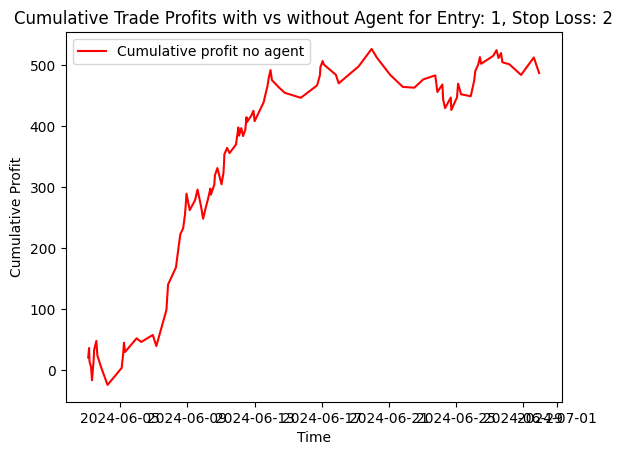

[np.float64(-4.397513480370103), np.float64(38.86163871870079), np.float64(21.270220367462787), np.float64(41.91710334866447), np.float64(22.325591132441293), np.float64(27.16425765124211), np.float64(-14.52664989310979), np.float64(-10.67052140076334), np.float64(-33.71916278324649), np.float64(40.082797493673894), np.float64(36.00436650866045), np.float64(31.763476009528496), np.float64(23.363813942726445), np.float64(20.43004092574695), np.float64(12.647687406133826), np.float64(-26.039710382505447), np.float64(24.59755999449476), np.float64(25.805893117069285), np.float64(-4.64711520290119), np.float64(9.216713896398844), np.float64(29.56708738078914), np.float64(-38.916320472817034), np.float64(-2.4738826649204384), np.float64(-24.541668279181675), np.float64(-19.730830821422085), np.float64(-17.691191778774094), np.float64(-42.524423153781285), np.float64(34.56580725018986), np.float64(-22.542697127829577), np.float64(19.386588601246828), np.float64(17.29847101640798), np.float64

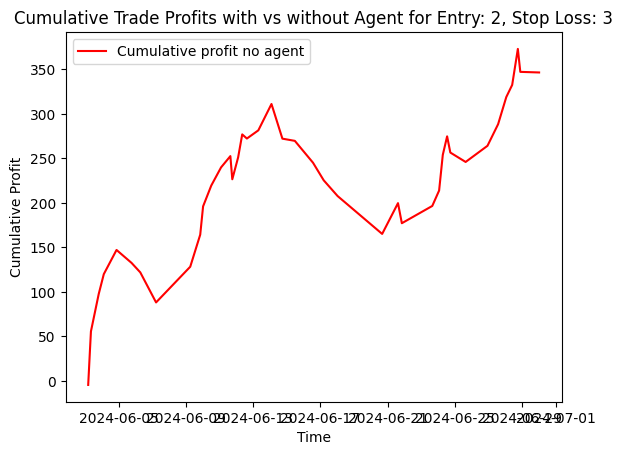

[np.float64(47.3094581766251), np.float64(-62.36700230958536), np.float64(-9.735804480014963), np.float64(32.40774421877939), np.float64(-95.12152069127254), np.float64(-40.78061678529809), np.float64(17.492780501140615), np.float64(45.55821340593715), np.float64(14.005877594808567), np.float64(42.11104898573243)]
Number of trades:  10
Percentage_Return:  -0.09119821383147703 %


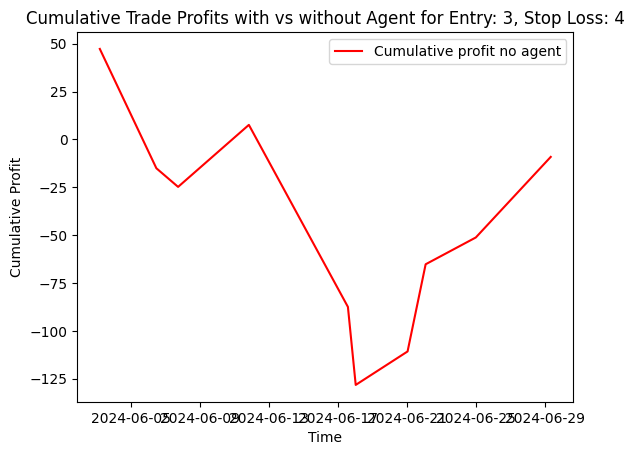

[np.float64(62.33866669478057), np.float64(-15.738791926111144)]
Number of trades:  2
Percentage_Return:  0.46599874768669425 %


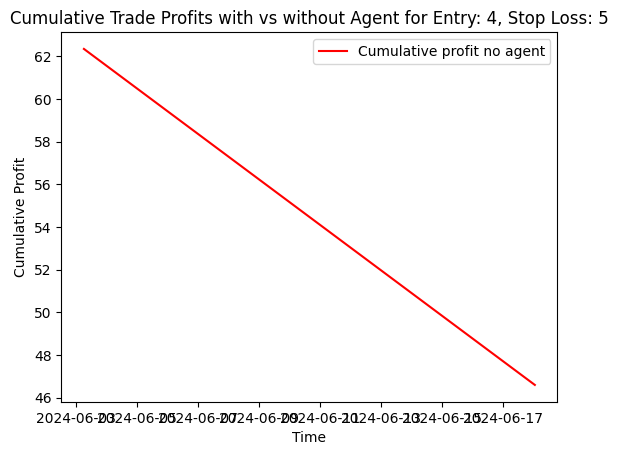

In [27]:

exit_threshold = 0
#tx_cost = 0.00025

#entry_stop_pairs = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 6)]

for entry_stop_pair in entry_stop_pairs:
    entry_threshold, stop_loss_threshold = entry_stop_pair
    
    #TEST DATA
    #----------
    positions, trade_entries, trade_exits = backtest_pair_rolling(S1_test,S2_test,zscore_series_test, entry_threshold, exit_threshold, stop_loss_threshold)
    trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_test, tx_cost)

    # #TRAIN DATA
    # #----------
    # positions, trade_entries, trade_exits = backtest_pair_rolling(S1_train,S2_train,zscore_series_train, entry_threshold, exit_threshold, stop_loss_threshold)
    # trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_train, tx_cost)

    #VAL DATA
    #----------
    # positions, trade_entries, trade_exits = backtest_pair_rolling(S1_val,S2_val,zscore_series_val, entry_threshold, exit_threshold, stop_loss_threshold)
    # trade_profits_no_agent, net_trade_profits_S1_no_agent, net_trade_profits_S2_no_agent,cumulative_profit_series_no_agent, entry_times_no_agent, exit_times_no_agent = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series_val, tx_cost)

    print(trade_profits_no_agent)
    #cumulative_profit_series_no_agent_indexed = cumulative_profit_series_no_agent.reindex(prices_test.index, method='ffill').fillna(0)
    print("Number of trades: ", len(trade_profits_no_agent))
    #print(cumulative_profit_series_no_agent)
    plt.plot(cumulative_profit_series_no_agent, color = 'red', label = 'Cumulative profit no agent') #Cumulative profits without agent
    print("Percentage_Return: ", (cumulative_profit_series_no_agent[-1] / initial_capital) * 100,"%")
    plt.title(f'Cumulative Trade Profits with vs without Agent for Entry: {entry_threshold}, Stop Loss: {stop_loss_threshold}')
    plt.xlabel('Time')
    plt.ylabel('Cumulative Profit')
    plt.legend()
    plt.show()